<a href="https://colab.research.google.com/github/AvantiShri/colab_notebooks/blob/master/SPI1_regression/TrainRegressionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
![[ -e SPI1_negatives.tsv.gz ]] || wget -O SPI1_negatives.tsv.gz http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_negatives.tsv.gz -O SPI1_negatives.tsv.gz
![[ -e SPI1_positives_regression_labels.tsv.gz ]] || wget -O SPI1_positives_regression_labels.tsv.gz http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_positives_regression_labels.tsv.gz

#download hg38 fasta file
![[ -e hg38.fa ]] || wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O hg38.fa.gz
![[ -e hg38.fa ]] || gunzip hg38.fa.gz

#install pyfaidx and prepare an index for hg38.fa
!pip install pyfaidx
from pyfaidx import Fasta
Fasta("hg38.fa") #this will build the index if it does not exist

--2019-09-04 17:36:02--  http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_negatives.tsv.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 242572693 (231M) [application/x-gzip]
Saving to: ‘SPI1_negatives.tsv.gz’

SPI1_negatives.tsv. 100%[===================>] 231.33M  1.66MB/s    in 2m 17s  

2019-09-04 17:38:19 (1.69 MB/s) - ‘SPI1_negatives.tsv.gz’ saved [242572693/242572693]

--2019-09-04 17:38:20--  http://mitra.stanford.edu/kundaje/avanti/regression_labels_SPI1_GM12878/positives_in_peaks/SPI1_positives_regression_labels.tsv.gz
Resolving mitra.stanford.edu (mitra.stanford.edu)... 171.67.96.243
Connecting to mitra.stanford.edu (mitra.stanford.edu)|171.67.96.243|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4179271 (4.0M) [application/x-gzip]
Saving to: ‘

Fasta("hg38.fa")

In [0]:
![[ -e noheader_SPI1_negatives.tsv.gz ]] || zcat SPI1_negatives.tsv.gz | grep -v 'START' | gzip -c > noheader_SPI1_negatives.tsv.gz
![[ -e noheader_SPI1_positives_regression_labels.tsv.gz ]] || zcat SPI1_positives_regression_labels.tsv.gz | grep -v 'START' | gzip -c > noheader_SPI1_positives_regression_labels.tsv.gz

!zcat noheader_SPI1_negatives.tsv.gz | egrep -v -w 'chr1|chr8|chr21|chr22' | gzip -c > train_SPI1_negatives.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -v -w 'chr1|chr8|chr21|chr22' | gzip -c > train_SPI1_positives_regression_labels.tsv.gz
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr1|chr8|chr21' | gzip -c > test_SPI1_coords.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr1|chr8|chr21' | gzip -c >> test_SPI1_coords.tsv.gz

In [0]:
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr1' | gzip -c > minitrain_SPI1_negatives.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr1' | gzip -c > minitrain_SPI1_positives_regression_labels.tsv.gz

In [4]:
#num negs in validation set
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr22'  | wc -l

995472


In [5]:
#num pos in validation set
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr22' | wc -l

6127


In [6]:
#combine the positives and negatives in the validation set; subsample the
# validation set for speed of calculation
!zcat noheader_SPI1_negatives.tsv.gz | egrep -w 'chr22' | perl -ne 'if ($.%25==0) {print $_}' | gzip -c > negsubsampled_valid.tsv.gz
!zcat noheader_SPI1_positives_regression_labels.tsv.gz | egrep -w 'chr22' | gzip -c >> negsubsampled_valid.tsv.gz
!zcat negsubsampled_valid.tsv.gz | wc -l

45945


In [18]:
pip install tqdm

In [7]:
!git clone https://github.com/kundajelab/seqdataloader.git

Cloning into 'seqdataloader'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 1078 (delta 33), reused 58 (delta 20), pack-reused 1003
Receiving objects: 100% (1078/1078), 3.90 MiB | 3.04 MiB/s, done.
Resolving deltas: 100% (659/659), done.


In [1]:
%cd /content/seqdataloader
!git checkout downsamplenegatives
!git pull
!pip uninstall seqdataloader
!pip install .
%cd /content

/content/seqdataloader
Already on 'downsamplenegatives'
Your branch is up to date with 'origin/downsamplenegatives'.
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 7 (delta 4), reused 7 (delta 4), pack-reused 0
Unpacking objects: 100% (7/7), done.
From https://github.com/kundajelab/seqdataloader
   1d14e82..7ee5104  downsamplenegatives -> origin/downsamplenegatives
Updating 1d14e82..7ee5104
Fast-forward
 seqdataloader/batchproducers/coordbased/coordstovals/lookup.py | 7 ++++---
 1 file changed, 4 insertions(+), 3 deletions(-)
Uninstalling seqdataloader-0.126:
  Would remove:
    /usr/local/bin/db_ingest
    /usr/local/bin/genomewide_labels
    /usr/local/lib/python3.6/dist-packages/seqdataloader-0.126.dist-info/*
    /usr/local/lib/python3.6/dist-packages/seqdataloader/batchproducers/*
    /usr/local/lib/python3.6/dist-packages/seqdataloader/dbingest/*
    /usr/local/lib/python3.6/dist-pa

In [2]:
from seqdataloader.batchproducers import coordbased
import numpy as np

labels_coordstovals = coordbased.coordstovals.lookup.SimpleLookup(
    lookup_file="noheader_SPI1_positives_regression_labels.tsv.gz")
input_coordstovals = coordbased.coordstovals.fasta.PyfaidxCoordsToVals(
    genome_fasta_path="hg38.fa")

valid_batchproducer = coordbased.coordbatchproducers.SimpleCoordsBatchProducer(
    bed_file="negsubsampled_valid.tsv.gz",
    batch_size=64,
    shuffle_before_epoch=False,
    seed=None)

train_batchproducer = (
  coordbased.coordbatchproducers.DownsampleNegativesCoordsBatchProducer(
    pos_bed_file="minitrain_SPI1_positives_regression_labels.tsv.gz",
    neg_bed_file="minitrain_SPI1_negatives.tsv.gz",
    target_proportion_positives=0.5,
    batch_size=64,
    shuffle_before_epoch=True,
    seed=1234))

train_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=train_batchproducer,
    inputs_coordstovals=input_coordstovals,
    targets_coordstovals=labels_coordstovals,
    coordsbatch_transformer=\
      coordbased.coordbatchtransformers.ReverseComplementAugmenter())

valid_batch_generator = coordbased.core.KerasBatchGenerator(
    coordsbatch_producer=valid_batchproducer,
    inputs_coordstovals=input_coordstovals,
    targets_coordstovals=labels_coordstovals)


Using TensorFlow backend.


Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Reading in positive bed file
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Got 31302  coords in positive bed file
Reading in negative bed file
Heads up: coordinates in bed file are assumed to be on the positive strand; if strand in the bed file is improtant to you, please add that feature to SimpleCoordsBatchProducer
Got 4881439  coords in negative bed file
The target proportion of positives of 0.5 requires the negative set to be subsampled by a factor of 156 which will result in a #neg of 31291
Using an offset of  0  before striding


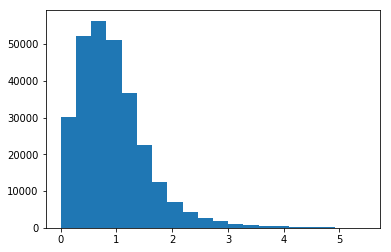

In [3]:
vals = list(labels_coordstovals.lookup.values())
from matplotlib import pyplot as plt
plt.hist(np.array(vals).squeeze(), bins=20)
plt.show()

In [7]:
import keras
from keras import backend as K
import tensorflow as tf
from keras.callbacks import Callback
from tqdm import tqdm
from scipy.stats import spearmanr


def predict_on_datagenerator(datagenerator, model):
  total_positives_preds = []
  total_positives_labels = []
  total_negatives_preds = []
  total_negatives_labels = []
  for batch_num in tqdm(range(len(datagenerator))):
    batch_inputs, batch_labels = datagenerator[batch_num]
    batch_preds = model.predict(batch_inputs)
    batch_preds, batch_labels = (np.squeeze(batch_preds),
                                 np.squeeze(batch_labels))
    assert len(batch_labels.shape)==1
    positives_mask = batch_labels > 0.0
    negatives_mask = positives_mask==False
    total_positives_preds.extend(batch_preds[positives_mask])
    total_positives_labels.extend(batch_labels[positives_mask])
    total_negatives_preds.extend(batch_preds[negatives_mask])
    total_negatives_labels.extend(batch_labels[negatives_mask])

  total_positives_preds = np.array(total_positives_preds)
  total_positives_labels = np.array(total_positives_labels)
  total_negatives_preds = np.array(total_negatives_preds)
  total_negatives_labels = np.array(total_negatives_labels)
  
  return (total_positives_preds, total_positives_labels,
          total_negatives_preds, total_negatives_labels)


class SeparatePositivesNegativesMseHistory(Callback):
  
  def __init__(self, datasetname, datagenerator, interval_of_evaluation):
    self.datasetname = datasetname
    self.datagenerator = datagenerator
    self.interval_of_evaluation = interval_of_evaluation
    self.batches_since_last_eval = 0
    self.positives_mse_history = []
    self.recentered_positives_mse_history = []
    self.positives_spearman_history = []
    self.negatives_mse_history = []
    self.recentered_negatives_mse_history = []
    
  def on_batch_end(self, *args, **kwargs):
    
    self.batches_since_last_eval =(
      (1+self.batches_since_last_eval)%self.interval_of_evaluation)
    
    if (self.batches_since_last_eval==0):   
      
      (total_positives_preds, total_positives_labels,
        total_negatives_preds, total_negatives_labels) = (
        predict_on_datagenerator(datagenerator=self.datagenerator,
                                 model=self.model))
         
      num_positives = len(total_positives_preds)
      num_negatives = len(total_negatives_preds)
      
      positives_mse = np.mean(
          np.square(total_positives_preds-total_positives_labels))
      negatives_mse = np.mean(
          np.square(total_negatives_preds-total_negatives_labels))
      recentered_positives_mse = np.mean(
          np.square((total_positives_preds-np.mean(total_positives_preds))
                    -(total_positives_labels-np.mean(total_positives_labels))))
      recentered_negatives_mse = np.mean(
          np.square((total_negatives_preds-np.mean(total_negatives_preds))
                    -(total_negatives_labels-np.mean(total_negatives_labels))))
      
      positives_spearman = spearmanr(a=total_positives_preds,
                                     b=total_positives_labels)[0]
      
      self.positives_spearman_history.append(positives_spearman)
      self.positives_mse_history.append(positives_mse)
      self.recentered_positives_mse_history.append(recentered_positives_mse)
      self.negatives_mse_history.append(negatives_mse)
      self.recentered_negatives_mse_history.append(recentered_negatives_mse)

      print("\n"+self.datasetname+": Mean mse over",num_positives,
            "positives is",positives_mse,
            "recentered",recentered_positives_mse)
      print(self.datasetname+": positives spearman",positives_spearman)
      print(self.datasetname+": Mean mse over",num_negatives,
            "negatives is",negatives_mse,
            "recentered",recentered_negatives_mse)
    

class CatchOverfittingOnPositives(SeparatePositivesNegativesMseHistory):
  
  def __init__(self, validation_data, interval_of_evaluation, patience):
    super(CatchOverfittingOnPositives, self).__init__(
        datasetname="validation set",
        datagenerator=validation_data,
        interval_of_evaluation=interval_of_evaluation)
    self.patience = patience
    self.rounds_waited = 0
    self.best_positives_loss = None
    self.best_weights = None
    self.stopped_epoch = None
    
  def on_batch_end(self, *args, **kwargs):
    
    super(CatchOverfittingOnPositives, self).on_batch_end(*args, **kwargs)
    if (self.batches_since_last_eval==0):  
      recentered_positives_mse = self.recentered_positives_mse_history[-1]
      if (self.best_positives_loss is None or
          self.best_positives_loss >= recentered_positives_mse):
        self.best_weights = self.model.get_weights()
        self.best_positives_loss = recentered_positives_mse
        self.rounds_waited = 0
      else:
        self.rounds_waited += 1
        if (self.rounds_waited >= self.patience):
          self.model.stop_training = True
          print("Restoring weights from the best round")
          self.model.set_weights(self.best_weights)
    

def manual_mse(y_true, y_pred):
  return K.mean(K.square(y_pred-y_true), axis=-1)

def mse_on_positives(y_true, y_pred):
  the_mask = tf.greater(y_true, 0.0)
  masked_y_true = tf.boolean_mask(y_true, the_mask)
  masked_y_pred = tf.boolean_mask(y_pred, the_mask)
  return K.mean(K.square(masked_y_pred-masked_y_true),axis=-1)

def mse_on_negatives(y_true, y_pred):
  the_mask = tf.equal(y_true, 0.0)
  masked_y_true = tf.boolean_mask(y_true, the_mask)
  masked_y_pred = tf.boolean_mask(y_pred, the_mask)
  return K.mean(K.square(masked_y_pred-masked_y_true),axis=-1)


def get_model(num_conv_filters,
              conv_filter_length,
              pool_length_and_stride,
              num_dense_units,
              adam_lr):
  input = keras.layers.Input(shape=(1000,4), name="sequence")
  conv1 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters, kernel_size=conv_filter_length,
              padding="same")(input)
  conv1batchnorm = keras.layers.normalization.BatchNormalization()(conv1)
  conv1relu = keras.layers.core.Activation(activation="relu")(conv1batchnorm)
  conv2 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv1relu)
  conv2batchnorm = keras.layers.normalization.BatchNormalization()(conv2)
  conv2relu = keras.layers.core.Activation(activation="relu")(conv2batchnorm)
  conv3 = keras.layers.convolutional.Conv1D(
              filters=num_conv_filters,
              kernel_size=conv_filter_length,
              padding="same")(conv2relu)
  conv3batchnorm = keras.layers.normalization.BatchNormalization()(conv3)
  conv3relu = keras.layers.core.Activation(activation="relu")(conv3batchnorm)
  avgpool = keras.layers.convolutional.AveragePooling1D(
                pool_size=pool_length_and_stride,
                strides=pool_length_and_stride)(conv3relu)
  flatten = keras.layers.core.Flatten()(avgpool)
  dense1 = keras.layers.core.Dense(units=num_dense_units)(flatten)
  dense1relu = keras.layers.core.Activation(activation="relu")(dense1)
  dense2 = keras.layers.core.Dense(units=num_dense_units)(dense1relu)
  dense2relu = keras.layers.core.Activation(activation="relu")(dense2)
  output = keras.layers.core.Dense(units=1,
                                   name="output")(dense2relu)
  conv_model = keras.models.Model(inputs=input, outputs=output)
  conv_model.compile(optimizer=keras.optimizers.Adam(lr=adam_lr),
                     loss={"output": "mse"},
                     metrics=[mse_on_positives,
                              mse_on_negatives,
                              manual_mse])
  return conv_model

conv_model = get_model(num_conv_filters=30,
                       conv_filter_length=15,
                       pool_length_and_stride=40,
                       num_dense_units=30,
                       adam_lr=0.0001)

conv_model.summary()
early_stopping_callback = CatchOverfittingOnPositives(
                              validation_data=valid_batch_generator,
                              interval_of_evaluation=len(train_batch_generator),
                              patience=20)
fit_history = conv_model.fit_generator(
  #x=train_batch_generator[0][0],
  #y=train_batch_generator[0][1],
  generator=train_batch_generator,
  epochs=300,
  callbacks=[early_stopping_callback,
             SeparatePositivesNegativesMseHistory(
              datasetname="minitrain",
              datagenerator=train_batch_generator,
              interval_of_evaluation=len(train_batch_generator))]
)
#the callback isn't triggered if the upper epoch limit is hit,
# so make sure the set the weights from the best epoch at the end
conv_model.set_weights(early_stopping_callback.best_weights)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequence (InputLayer)        (None, 1000, 4)           0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1000, 30)          1830      
_________________________________________________________________
batch_normalization_13 (Batc (None, 1000, 30)          120       
_________________________________________________________________
activation_21 (Activation)   (None, 1000, 30)          0         
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1000, 30)          13530     
_________________________________________________________________
batch_normalization_14 (Batc (None, 1000, 30)          120       
_________________________________________________________________
activation_22 (Activation)   (None, 1000, 30)          0   

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  8  before striding


  0%|          | 0/979 [00:00<?, ?it/s]


validation set: Mean mse over 6127 positives is 0.41459083803529845 recentered 0.37599956260215495
validation set: positives spearman 0.2610809876340915
validation set: Mean mse over 39818 negatives is 0.3363331005212134 recentered 0.104417537793224


100%|██████████| 979/979 [01:37<00:00, 11.76it/s]


minitrain: Mean mse over 62604 positives is 0.419852476774897 recentered 0.37827315173140286
minitrain: positives spearman 0.2768180784081128
minitrain: Mean mse over 62584 negatives is 0.3352549019752822 recentered 0.06187160328338523
979/979 [==============================] - 234s 239ms/step - loss: 0.3724 - mse_on_positives: 0.5398 - mse_on_negatives: 0.2049 - manual_mse: 0.3724


Epoch 2/300
978/979 [============================>.] - ETA: 0s - loss: 0.3429 - mse_on_positives: 0.5043 - mse_on_negatives: 0.1815 - manual_mse: 0.3429Using an offset of  9  before striding


  0%|          | 2/979 [00:00<01:33, 10.44it/s]


validation set: Mean mse over 6127 positives is 0.5432309367385423 recentered 0.38155455299088814
validation set: positives spearman 0.25312682537728837
validation set: Mean mse over 39818 negatives is 0.13933169164761844 recentered 0.06641497633417535


100%|██████████| 979/979 [01:36<00:00, 11.67it/s]


minitrain: Mean mse over 62604 positives is 0.5575368985014083 recentered 0.3791843946642904
minitrain: positives spearman 0.2936150295867173
minitrain: Mean mse over 62584 negatives is 0.11679816519097398 recentered 0.04976693396518148
979/979 [==============================] - 232s 237ms/step - loss: 0.3428 - mse_on_positives: 0.5041 - mse_on_negatives: 0.1815 - manual_mse: 0.3428


Epoch 3/300
978/979 [============================>.] - ETA: 0s - loss: 0.3252 - mse_on_positives: 0.4837 - mse_on_negatives: 0.1667 - manual_mse: 0.3252Using an offset of  10  before striding


  0%|          | 2/979 [00:00<01:35, 10.27it/s]


validation set: Mean mse over 6127 positives is 0.6449335479748024 recentered 0.39363993760847704
validation set: positives spearman 0.18714911722349406
validation set: Mean mse over 39818 negatives is 0.08490415783342256 recentered 0.04826400590110953


100%|██████████| 979/979 [01:37<00:00, 11.90it/s]


minitrain: Mean mse over 62604 positives is 0.5861605222317117 recentered 0.3765137352868328
minitrain: positives spearman 0.26833430065113467
minitrain: Mean mse over 62584 negatives is 0.09139830007802452 recentered 0.0424979300251708
979/979 [==============================] - 231s 236ms/step - loss: 0.3252 - mse_on_positives: 0.4837 - mse_on_negatives: 0.1666 - manual_mse: 0.3252


Epoch 4/300
978/979 [============================>.] - ETA: 0s - loss: 0.3138 - mse_on_positives: 0.4715 - mse_on_negatives: 0.1560 - manual_mse: 0.3138

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  11  before striding


  0%|          | 1/979 [00:00<01:38,  9.91it/s]


validation set: Mean mse over 6127 positives is 0.39864208443027005 recentered 0.39403034837836204
validation set: positives spearman 0.23390741198732298
validation set: Mean mse over 39818 negatives is 0.3271029393585282 recentered 0.13049730382300237


100%|██████████| 979/979 [01:37<00:00, 10.03it/s]


minitrain: Mean mse over 62604 positives is 0.3778209170019422 recentered 0.37410073783057574
minitrain: positives spearman 0.3176923618257737
minitrain: Mean mse over 62584 negatives is 0.31414601170873635 recentered 0.0972863772653197
979/979 [==============================] - 233s 238ms/step - loss: 0.3140 - mse_on_positives: 0.4719 - mse_on_negatives: 0.1560 - manual_mse: 0.3140
Epoch 5/300
  1/979 [..............................] - ETA: 45s - loss: 0.3328 - mse_on_positives: 0.4995 - mse_on_negatives: 0.1662 - manual_mse: 0.3328

978/979 [============================>.] - ETA: 0s - loss: 0.3002 - mse_on_positives: 0.4541 - mse_on_negatives: 0.1462 - manual_mse: 0.3002

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  12  before striding


  0%|          | 2/979 [00:00<01:35, 10.26it/s]


validation set: Mean mse over 6127 positives is 0.8247897266582871 recentered 0.3867424439706794
validation set: positives spearman 0.23203428038490148
validation set: Mean mse over 39818 negatives is 0.030911577135946125 recentered 0.02796441861663919


100%|██████████| 979/979 [01:37<00:00, 11.77it/s]


minitrain: Mean mse over 62604 positives is 0.7858415147343946 recentered 0.3573456177292677
minitrain: positives spearman 0.33659111443859185
minitrain: Mean mse over 62584 negatives is 0.024651130515595893 recentered 0.023921936999668714
979/979 [==============================] - 231s 236ms/step - loss: 0.3002 - mse_on_positives: 0.4542 - mse_on_negatives: 0.1462 - manual_mse: 0.3002


Epoch 6/300
978/979 [============================>.] - ETA: 0s - loss: 0.2866 - mse_on_positives: 0.4374 - mse_on_negatives: 0.1358 - manual_mse: 0.2866

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  13  before striding


  0%|          | 1/979 [00:00<01:37,  9.98it/s]


validation set: Mean mse over 6127 positives is 0.4528219391698508 recentered 0.40929675444812086
validation set: positives spearman 0.2263775002671138
validation set: Mean mse over 39818 negatives is 0.18162304344981972 recentered 0.09404391211873193


100%|██████████| 979/979 [01:38<00:00,  9.92it/s]


minitrain: Mean mse over 62604 positives is 0.3920476710820418 recentered 0.35548237120823806
minitrain: positives spearman 0.3613019829819041
minitrain: Mean mse over 62584 negatives is 0.15957739244903596 recentered 0.07376380331643287
979/979 [==============================] - 233s 238ms/step - loss: 0.2867 - mse_on_positives: 0.4376 - mse_on_negatives: 0.1358 - manual_mse: 0.2867
Epoch 7/300
  1/979 [..............................] - ETA: 43s - loss: 0.2119 - mse_on_positives: 0.2694 - mse_on_negatives: 0.1544 - manual_mse: 0.2119

978/979 [============================>.] - ETA: 0s - loss: 0.2731 - mse_on_positives: 0.4191 - mse_on_negatives: 0.1270 - manual_mse: 0.2731

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  14  before striding


  0%|          | 1/979 [00:00<01:40,  9.77it/s]


validation set: Mean mse over 6127 positives is 0.894370610856294 recentered 0.4189257043842399
validation set: positives spearman 0.17519966431961576
validation set: Mean mse over 39818 negatives is 1.3272770736085289 recentered 0.39518031633699374


100%|██████████| 979/979 [01:37<00:00, 10.06it/s]


minitrain: Mean mse over 62604 positives is 0.9287534090403728 recentered 0.3557862367171751
minitrain: positives spearman 0.343011202114544
minitrain: Mean mse over 62584 negatives is 1.4866669290656165 recentered 0.23301456270514614
979/979 [==============================] - 232s 237ms/step - loss: 0.2731 - mse_on_positives: 0.4191 - mse_on_negatives: 0.1270 - manual_mse: 0.2731
Epoch 8/300
  1/979 [..............................] - ETA: 47s - loss: 0.2550 - mse_on_positives: 0.4285 - mse_on_negatives: 0.0815 - manual_mse: 0.2550

978/979 [============================>.] - ETA: 0s - loss: 0.2628 - mse_on_positives: 0.4056 - mse_on_negatives: 0.1199 - manual_mse: 0.2628

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  15  before striding


  0%|          | 1/979 [00:00<01:49,  8.95it/s]


validation set: Mean mse over 6127 positives is 0.4820338870489383 recentered 0.4423375990205671
validation set: positives spearman 0.2502899889121203
validation set: Mean mse over 39818 negatives is 0.45897703547446655 recentered 0.21630606385496282


100%|██████████| 979/979 [01:37<00:00, 10.06it/s]


minitrain: Mean mse over 62604 positives is 0.39654969431491155 recentered 0.35841759795876516
minitrain: positives spearman 0.41270964860092063
minitrain: Mean mse over 62584 negatives is 0.38253295516187374 recentered 0.15302162703190156
979/979 [==============================] - 232s 237ms/step - loss: 0.2628 - mse_on_positives: 0.4056 - mse_on_negatives: 0.1199 - manual_mse: 0.2628


Epoch 9/300
978/979 [============================>.] - ETA: 0s - loss: 0.2530 - mse_on_positives: 0.3908 - mse_on_negatives: 0.1151 - manual_mse: 0.2530Using an offset of  16  before striding


  0%|          | 1/979 [00:00<01:37,  9.99it/s]


validation set: Mean mse over 6127 positives is 0.4625712718037623 recentered 0.4435843601744016
validation set: positives spearman 0.2032284441136462
validation set: Mean mse over 39818 negatives is 0.1958196178761262 recentered 0.10987765760425759


100%|██████████| 979/979 [01:37<00:00, 11.56it/s]


minitrain: Mean mse over 62604 positives is 0.3321163621141795 recentered 0.3273840739981389
minitrain: positives spearman 0.4155633324745053
minitrain: Mean mse over 62584 negatives is 0.1853105010016543 recentered 0.0895754256566627
979/979 [==============================] - 231s 236ms/step - loss: 0.2529 - mse_on_positives: 0.3907 - mse_on_negatives: 0.1151 - manual_mse: 0.2529


Epoch 10/300
978/979 [============================>.] - ETA: 0s - loss: 0.2440 - mse_on_positives: 0.3778 - mse_on_negatives: 0.1101 - manual_mse: 0.2440

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  17  before striding


  0%|          | 1/979 [00:00<01:39,  9.87it/s]


validation set: Mean mse over 6127 positives is 0.7832981962935301 recentered 0.4061137924835004
validation set: positives spearman 0.20664819310176508
validation set: Mean mse over 39818 negatives is 0.0298164337931958 recentered 0.027649218152397355


100%|██████████| 979/979 [01:36<00:00, 11.69it/s]


minitrain: Mean mse over 62604 positives is 0.6268224614564022 recentered 0.30555195303991955
minitrain: positives spearman 0.4240619705831818
minitrain: Mean mse over 62584 negatives is 0.02403346029473822 recentered 0.022965658521954566
979/979 [==============================] - 230s 235ms/step - loss: 0.2439 - mse_on_positives: 0.3777 - mse_on_negatives: 0.1101 - manual_mse: 0.2439


Epoch 11/300
978/979 [============================>.] - ETA: 0s - loss: 0.2347 - mse_on_positives: 0.3628 - mse_on_negatives: 0.1065 - manual_mse: 0.2347

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of  18  before striding


  0%|          | 1/979 [00:00<01:39,  9.84it/s]


validation set: Mean mse over 6127 positives is 0.5136363405854126 recentered 0.45173989168933526
validation set: positives spearman 0.21129652273409566
validation set: Mean mse over 39818 negatives is 0.13065988309509974 recentered 0.0811901231860693


100%|██████████| 979/979 [01:36<00:00, 11.87it/s]


minitrain: Mean mse over 62604 positives is 0.34092574785518914 recentered 0.3040491882128439
minitrain: positives spearman 0.4588771269810121
minitrain: Mean mse over 62584 negatives is 0.10705908880641765 recentered 0.061272441166215705
979/979 [==============================] - 232s 237ms/step - loss: 0.2346 - mse_on_positives: 0.3625 - mse_on_negatives: 0.1066 - manual_mse: 0.2346


Epoch 12/300
978/979 [============================>.] - ETA: 0s - loss: 0.2293 - mse_on_positives: 0.3536 - mse_on_negatives: 0.1048 - manual_mse: 0.2293

  0%|          | 0/718 [00:00<?, ?it/s]

Using an offset of 

  0%|          | 1/718 [00:00<01:12,  9.88it/s]

 19  before striding


  0%|          | 2/979 [00:00<01:34, 10.30it/s]


validation set: Mean mse over 6127 positives is 0.562526922092955 recentered 0.5003445339768093
validation set: positives spearman 0.22232512229473775
validation set: Mean mse over 39818 negatives is 0.45326627121330576 recentered 0.2186204521577894


100%|██████████| 979/979 [01:38<00:00, 11.58it/s]


minitrain: Mean mse over 62604 positives is 0.4156877630138549 recentered 0.32110311456643303
minitrain: positives spearman 0.47898913306406393
minitrain: Mean mse over 62584 negatives is 0.3930797993261374 recentered 0.1606564690274058
979/979 [==============================] - 232s 237ms/step - loss: 0.2293 - mse_on_positives: 0.3537 - mse_on_negatives: 0.1048 - manual_mse: 0.2293


Epoch 13/300
150/979 [===>..........................] - ETA: 1:20 - loss: 0.2254 - mse_on_positives: 0.3463 - mse_on_negatives: 0.1045 - manual_mse: 0.2254

KeyboardInterrupt: ignored

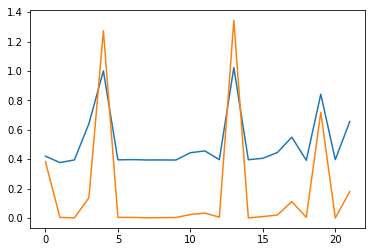

In [9]:
from matplotlib import pyplot as plt
plt.plot(np.arange(len(early_stopping_callback.recentered_positives_mse_history)),
         early_stopping_callback.recentered_positives_mse_history)
plt.plot(np.arange(len(early_stopping_callback.recentered_positives_mse_history)),
         early_stopping_callback.recentered_negatives_mse_history)